<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Ranidu-Gurusinghe/Model_Selection_and_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [1]:
!pip install catboost

In [2]:
!pip install scikit-learn==1.4.1.post1

In [21]:
import pandas as pd
import numpy as np


from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn. linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn. ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib

In [22]:
!python -m pip show scikit-learn


Name: scikit-learn
Version: 1.4.1.post1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


Reading data

In [23]:
drive.mount('/content/drive')
# Load the preprocessed data
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
data

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Absent/Present,Reason,Joined Date,...,LeaveMonth,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeaveYear,NumOfLeaveDays,TookLeaveNextMonth,LeavesNextMonth,TargetCategory
0,2021-12-01,Shift A,AA369,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2015-09-11,...,12,11,1,0,0,2021,4,0,0,A
1,2021-12-01,Shift A,AA362,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2018-11-14,...,12,11,1,0,0,2021,4,1,24,C
2,2021-12-01,Shift A,AA359,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2019-10-09,...,12,11,1,0,0,2021,4,1,16,C
3,2021-12-01,Shift A,AA541,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2020-10-02,...,12,11,1,0,0,2021,4,1,2,B
4,2021-12-01,Shift A,AA398,Team - MAT 3A - BD,Informed,Notified,1,MAT,Maternity,2008-02-29,...,12,11,1,0,0,2021,4,1,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40661,2023-12-22,Shift A,AA2212,Sewing Team - 145A - II - BD,Uninformed,Notified,1,Absent,Health Related,2018-06-12,...,12,9,1,1,0,2023,1,0,0,A
40662,2023-12-22,Shift A,AA723,Sewing Team - 109A - I - BD,Informed,Notified,1,Absent,Personal Reason,2017-11-15,...,12,15,1,0,0,2023,1,0,0,A
40663,2023-12-22,Shift A,AA1280,Sewing Team - 152A - I - BD,Informed,Notified,1,Absent,Personal Reason,2018-12-19,...,12,15,1,0,0,2023,1,0,0,A
40664,2023-12-22,Shift A,AA1964,Sewing Team - 135A - I - BD,Informed,Notified,1,Absent,Personal Reason,2021-07-02,...,12,15,1,0,0,2023,1,0,0,A


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40666 entries, 0 to 40665
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      40666 non-null  datetime64[ns]
 1   Shift                     40666 non-null  object        
 2   Code                      40666 non-null  object        
 3   Department                40666 non-null  object        
 4   Absenteeism Type          40659 non-null  object        
 5   Status                    40666 non-null  object        
 6   Leave Type                40666 non-null  int64         
 7   Absent/Present            40666 non-null  object        
 8   Reason                    40666 non-null  object        
 9   Joined Date               40666 non-null  datetime64[ns]
 10  DaysWorked                40666 non-null  int64         
 11  DayOfWeek                 40666 non-null  int64         
 12  Encoded Code      

##Preprocessing

In [26]:
def onehot_encode(df, column, prefix):
    df = df.copy()

    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)

    return df

In [29]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop ID columns

    df = df.drop('Code', axis=1)
    df = df.drop('Shift', axis=1)
    df = df.drop('Department', axis=1)
    df = df.drop('Absenteeism Type', axis=1)
    df = df.drop('Status', axis=1)
    df = df.drop('Leave Type', axis=1)
    df = df.drop('Absent/Present', axis=1)
    df = df.drop('Reason', axis=1)
    df = df.drop('Joined Date', axis=1)
    df = df.drop('TargetCategory', axis=1)
    df = df.drop('TookLeaveNextMonth', axis=1)
    # One-hot encode the reason column
    df = onehot_encode(
        df,
        column='Encoded Reason',
        prefix='Reason'
    )

    # Filter the data for November 2023
    testing_data_november = df[(df['LeaveYear'] == 2023) & (df['LeaveMonth'] >= 11)]

    df = df[df['Date'] < '2023-11-01']
    df = df.drop('Date', axis=1)
    # Split df into X and y
    y = df['LeavesNextMonth'].copy()
    X = df.drop('LeavesNextMonth', axis=1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
    # Scale X
    # scaler = StandardScaler()
    # scaler.fit(X_train)

    # X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    # X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    return testing_data_november, X_train, X_test, y_train, y_test

In [30]:
# Remove the November 2023 data from the original data
data = data[data['Date'] < '2023-12-01']

# Split the remaining data into training and testing sets
testing_data_november, X_train, X_test, y_train, y_test = preprocess_inputs(data)



# Print the last few rows of the testing data for November 2023
print("Last few rows of the testing data for November 2023:")
print(testing_data_november.tail())

# Save the testing data for November 2023 to an Excel file
testing_data_november_path = '/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/testing_data_november.xlsx'
testing_data_november.to_excel(testing_data_november_path, index=False)






Last few rows of the testing data for November 2023:
            Date  DaysWorked  DayOfWeek  Encoded Code  LeaveMonth  \
39739 2023-11-30         787          4          2754          11   
39740 2023-11-30         580          4          4194          11   
39741 2023-11-30         749          4          3880          11   
39742 2023-11-30         658          4          4261          11   
39743 2023-11-30         316          4          4106          11   

       Encoded Status  Encoded Absenteeism Type  Encoded Shift  LeaveYear  \
39739               1                         1              0       2023   
39740               1                         0              0       2023   
39741               1                         1              0       2023   
39742               0                         1              0       2023   
39743               1                         0              0       2023   

       NumOfLeaveDays  ...  Reason_9  Reason_10  Reason_11  Reason_12

In [31]:
X_train

,DaysWorked,DayOfWeek,Encoded Code,LeaveMonth,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeaveYear,NumOfLeaveDays,Reason_0,...,Reason_9,Reason_10,Reason_11,Reason_12,Reason_13,Reason_14,Reason_15,Reason_16,Reason_17,Reason_18
6093,3869,1,3407,2,0,1,0,2022,6,0,...,0,0,0,0,0,1,0,0,0,0
26398,5348,1,1077,11,1,0,1,2022,2,0,...,0,0,0,0,0,0,1,0,0,0
25545,1528,5,3411,11,1,0,0,2022,1,0,...,1,0,0,0,0,0,0,0,0,0
24680,4538,4,3542,10,1,0,1,2022,3,0,...,0,0,0,0,0,0,0,0,0,0
10755,1444,3,2446,4,1,0,0,2022,2,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,1401,4,2463,3,0,1,0,2022,1,0,...,0,0,0,0,0,1,0,0,0,0
15377,268,3,2889,6,0,1,1,2022,1,0,...,0,0,0,0,0,0,0,0,0,0
17730,246,5,3527,6,1,0,1,2022,1,0,...,0,0,0,0,0,0,1,0,0,0
28030,482,1,2927,1,1,0,1,2023,1,0,...,1,0,0,0,0,0,0,0,0,0


In [32]:
y_train

6093     0
26398    1
25545    0
24680    6
10755    0
        ..
7763     2
15377    4
17730    0
28030    1
15725    0
Name: LeavesNextMonth, Length: 30714, dtype: int64

##Trainning

In [ ]:
models = {
    "                     Linear Regression": LinearRegression(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(),
    "                     Gradient Boosting": GradientBoostingRegressor(),
    "                               XGBoost": XGBRegressor(),
    "                              LightGBM": LGBMRegressor(),
    "                              CatBoost": CatBoostRegressor(verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

In [ ]:
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(X_test, y_test)))

From the R2 Scores we can determine that Random Forest performs the best among everything else.

##Making Random Forest Model

In [33]:
rf_model = RandomForestRegressor(n_estimators=500, max_depth=40,random_state=123)
rf_model.fit(X_train, y_train)
# rf_model.save()
print("Random Forest Model R^2: {:.5f}".format(rf_model.score(X_test, y_test)))


Random Forest Model R^2: 0.60761


In [34]:
# Define a function to map predicted values to classes
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#ask stakeholders
def map_to_class(value):
    if value >= 4:
        return 'B'
    elif value >=0:
        return 'A'

# Make predictions on the test data
predictions_rf = rf_model.predict(X_test)
actual_classes = [map_to_class(value) for value in y_test]
# Map predicted values to classes
predicted_classes = [map_to_class(value) for value in predictions_rf]
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions_rf})
# Create a DataFrame to display actual and predicted values
results_classified_df = pd.DataFrame({'Actual': actual_classes, 'Predicted': predicted_classes})

# Calculate accuracy
accuracy = accuracy_score(actual_classes, predicted_classes)

print("Actual values and predictions:")
print(results_df)
print("\n\nAccuracy of Predicted Classes:", accuracy)

# Display the DataFrame
print(results_classified_df)


Actual values and predictions:
       Actual  Predicted
5066        8     11.582
19246      25     17.828
14748       2      1.870
15465       0      1.334
22343       0      8.940
...       ...        ...
29183       1      3.968
24323       0      1.912
36077       1      0.644
29391       0      0.020
29160       0      2.094

[7679 rows x 2 columns]


Accuracy of Predicted Classes: 0.8127360333376742
     Actual Predicted
0         B         B
1         B         B
2         A         A
3         A         A
4         A         B
...     ...       ...
7674      A         A
7675      A         A
7676      A         A
7677      A         A
7678      A         A

[7679 rows x 2 columns]


In [35]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(actual_classes, predicted_classes)

# Print the classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           A       0.91      0.82      0.86      5453
           B       0.64      0.79      0.71      2226

    accuracy                           0.81      7679
   macro avg       0.78      0.81      0.79      7679
weighted avg       0.83      0.81      0.82      7679



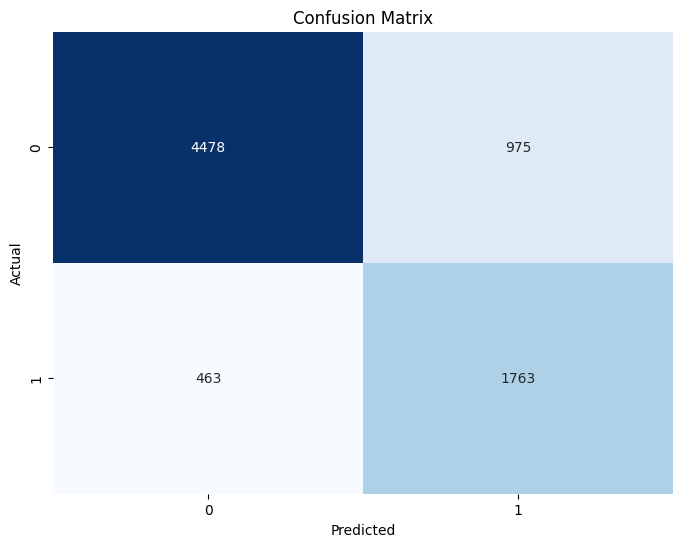

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(actual_classes, predicted_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [37]:
joblib.dump(rf_model, '/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Ranidu/rf_model.joblib')

['/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Ranidu/rf_model.joblib']

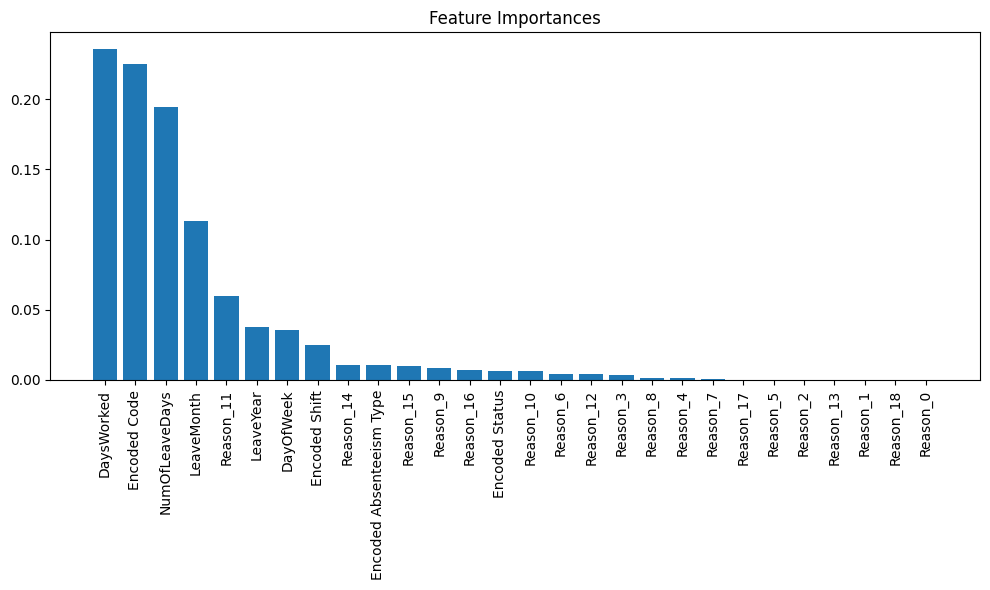

In [57]:
# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [58]:
from sklearn.metrics import roc_auc_score

# Assuming you have already trained your Random Forest model and made predictions
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of positive class
auc = roc_auc_score(y_test, y_pred_proba)

print("AUC Score:", auc)

AttributeError: 'RandomForestRegressor' object has no attribute 'predict_proba'

#Fuzzy logic classifier

In [ ]:
!pip install scikit-fuzzy

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define the universe variable
output = ctrl.Antecedent(np.arange(0, 26, 1), 'output')
classification = ctrl.Consequent(np.arange(0, 26, 1), 'classification')

# Define membership functions for output
output['A'] = fuzz.trimf(output.universe, [0, 1, 1])
output['B'] = fuzz.trimf(output.universe, [2, 3.5, 5])
output['C'] = fuzz.trimf(output.universe, [6, 25, 25])

# Define membership functions for classification
classification['A'] = fuzz.trimf(classification.universe, [0, 1, 1])
classification['B'] = fuzz.trimf(classification.universe, [2, 5, 5])
classification['C'] = fuzz.trimf(classification.universe, [6, 25, 25])

# Define rules
rule1 = ctrl.Rule(output['A'], classification['A'])
rule2 = ctrl.Rule(output['B'], classification['B'])
rule3 = ctrl.Rule(output['C'], classification['C'])

# Create and simulate control system
classify_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
classify = ctrl.ControlSystemSimulation(classify_ctrl)

# Input the output value from the random forest model
output_value = float(input("Enter the output value from the random forest model (0-25): "))

# Compute the classification
classify.input['output'] = output_value
classify.compute()

# Print the result
print("The classification is:", classify.output['classification'])
classification.view(sim=classify)
